![![University of Information Technology and Management in Rzeszow, Poland](https://gitlab.wsiz.pl/lgajecki/SA/-/raw/master/wsiz_eng.png)](wsiz_eng.png)

# Laboratory 6 (part 2) - Time series, LSTM cells

Sprawozdanie $\ \ \ \ \ \ \ \ $   Imie: .......Jakub..............  Nazwisko: ........Jop......  | Nr albumu : ........w67238............ | Ocena
:--|:--|:--
Efekt PU01 'Ocena rozwiązań problemów przygotowywanych w ramach poszczególnych laboratoriów' | - ocena za wykonanie ćwiczeń i ich interpretację. | _________/4 pkt(max)

Based on https://towardsdatascience.com/pytorch-lstms-for-time-series-data-cd16190929d7

Original sources in that paper come from https://gist.github.com/charlieoneill11 . However I've introduced few corrections (LSTM class and calling training loop)

LSTM cells explaned: https://towardsdatascience.com/how-the-lstm-improves-the-rnn-1ef156b75121

Documentation in Pytorch https://pytorch.org/docs/stable/nn.html#recurrent-layers

To learn the sequence we can use:
- any neural network: 
    - input: data at time t: x(t), or in general n last samples x(t-n+1),..,x(t)
    - output: data at next time t+1, x(t+1) , or in some future steps x(t+1)...x(t+m)
- recurrent neural network (RNN). Thhis network remeber previous state. The key point is that outputs are concatenated with inputs (so direct inputs are x(t),y(t-1) ). The outputs might be after some k layers (not only last layer), then first k layers will be recurrent layers, and further layers are foorward (classical) layers.
- LSTM cell , more complex case of RNN. Has however good properties (RNN may be unstable, ie positive feedforward make increasing signal).
  
Materials about LSTM:
[1] https://colah.github.io/posts/2015-08-Understanding-LSTMs/

[2] https://datascience.eu/pl/uczenie-maszynowe/zrozumienie-sieci-lstm/

[3] https://towardsdatascience.com/lstm-networks-a-detailed-explanation-8fae6aefc7f9

[4] https://www.geeksforgeeks.org/long-short-term-memory-networks-explanation/

[5] Pytorch LSTM: https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html#torch.nn.LSTMCell


h - is "real" output -called "hidden state" <br>
c - is "cell state" - internal state of LSTM cell

In Pytorch - you can provide initial c and h matrix, if not provided they will be zeros.
However if you calculate next step of the sequence - you need h and c matrix from previous step (for each LSTM layer separate one).

hidden_size - number of outputs (we can say number of "neurons", but all calculations here are matrix operations)<br>
input_size - number of inputs (size of input vector)

Example from [5]:

    rnn = nn.LSTMCell(10, 20) # (input_size, hidden_size)
    input = torch.randn(2, 3, 10) # (time_steps, batch, input_size)
    hx = torch.randn(3, 20) # (batch, hidden_size)
    cx = torch.randn(3, 20)
    output = []
    for i in range(input.size()[0]):
        hx, cx = rnn(input[i], (hx, cx))
        output.append(hx)
    output = torch.stack(output, dim=0)


In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch import optim

## 1. Simple dataset. 
Assume time series data. (Klay Tomposon - number of games after return from injury).

In [3]:
X = torch.Tensor([x for x in range(11)])
y = torch.Tensor([1.6*x + 4 + np.random.normal(10, 1) for x in X])
X, y

(tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 tensor([12.9241, 16.2541, 16.5142, 17.8334, 19.3395, 22.4392, 23.7458, 23.9591,
         25.1361, 25.7350, 30.9292]))

Samples

In [4]:
X_train = X[:9].unsqueeze(1)
y_train = y[:9].unsqueeze(1)
X_val = X[9:].unsqueeze(1)
y_val = y[9:].unsqueeze(1)
print(X.shape,y.shape,X_train.shape,y_train.shape,X_val.shape,y_val.shape)

torch.Size([11]) torch.Size([11]) torch.Size([9, 1]) torch.Size([9, 1]) torch.Size([2, 1]) torch.Size([2, 1])


Neural Network Model

In [5]:
seq_model = nn.Sequential(
    nn.Linear(1, 13),
    nn.Tanh(),
    nn.Linear(13, 1))
seq_model


Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

How to check network size? Tutorial : https://medium.com/the-owl/how-to-get-model-summary-in-pytorch-57db7824d1e3

You need to specify an input size, since in Pytorch (unlike Keras) the calculation graph is created dynamically. Sometimes, when `forward` function preform processing in loop (exercise 2) - the results might be interesting (multiplication of layers number by loop repetition)

Note, that those tools assumes, that your data contains batches,  so your input is size, for example *(N,L,H_in)*, where:
- *N* - Batch size
- *L* - sequence length (or number of vectors)
- *H_in* - the input vector size

When your real inputs is size *(L,H_in)* you need add batch dimension in such case.

Documentation, respectively: 
- https://github.com/sksq96/pytorch-summary
- https://pypi.org/project/torchinfo/

In [6]:
from torchsummary import summary
summary(seq_model,input_size=(9,1),batch_size=1)#batch_size=-1

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [1, 9, 13]              26
              Tanh-2                 [1, 9, 13]               0
            Linear-3                  [1, 9, 1]              14
Total params: 40
Trainable params: 40
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


Training

In [7]:
import torchinfo
torchinfo.summary(seq_model, (9,1), batch_dim = 0, 
                  col_names = ("input_size", "output_size", "num_params", 
                               "kernel_size", "mult_adds"), verbose = 0)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
Sequential                               [1, 9, 1]                 [1, 9, 1]                 --                        --                        --
├─Linear: 1-1                            [1, 9, 1]                 [1, 9, 13]                26                        --                        26
├─Tanh: 1-2                              [1, 9, 13]                [1, 9, 13]                --                        --                        --
├─Linear: 1-3                            [1, 9, 13]                [1, 9, 1]                 14                        --                        14
Total params: 40
Trainable params: 40
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [8]:
def training_loop1(n_epochs, optimiser, model, loss_fn, X_train,  X_val, y_train, y_val):
    for epoch in range(1, n_epochs + 1):
        output_train = model(X_train) # forwards pass
        loss_train = loss_fn(output_train, y_train) # calculate loss
        output_val = model(X_val) 
        loss_val = loss_fn(output_val, y_val)
        
        optimiser.zero_grad() # set gradients to zero
        loss_train.backward() # backwards pass
        optimiser.step() # update model parameters
        if epoch == 1 or epoch % 10000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

In [9]:
optimiser = optim.SGD(seq_model.parameters(), lr=1e-3)
training_loop1(
    n_epochs = 50000, 
    optimiser = optimiser,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    X_train = X_train,
    X_val = X_val, 
    y_train = y_train,
    y_val = y_val)

Epoch 1, Training loss 423.7332, Validation loss 830.5098
Epoch 10000, Training loss 0.2061, Validation loss 11.7904
Epoch 20000, Training loss 0.0929, Validation loss 13.1761
Epoch 30000, Training loss 0.0645, Validation loss 14.2007
Epoch 40000, Training loss 0.0587, Validation loss 14.4762
Epoch 50000, Training loss 0.0563, Validation loss 14.3667


Test results

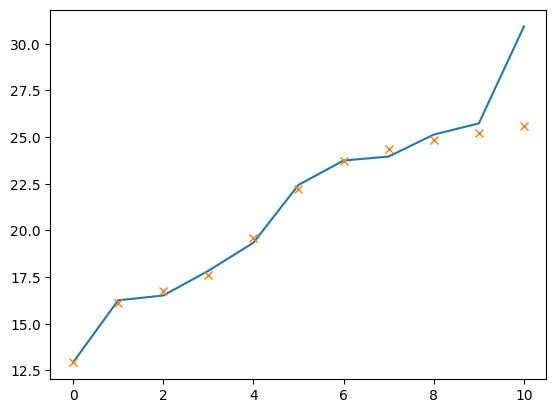

In [10]:
import matplotlib.pyplot as plt
plt.plot(X,y)
y_res=seq_model(X.unsqueeze(1))
plt.plot(X,y_res.detach(),'x')

**Ex 1.1** At which iteration you should stop above training process? Please perform training to estimated point of overfitting.

## 2) Dataset - set of sine waves

Generation of L sinusoids, for each sinusoid N samples 

In [11]:
N = 10 #100 number of samples, 100 need long time...
L = 1000 # length of each sample (number of values for each sine wave)
T = 20 # width of the wave
x = np.empty((N,L), np.float32) # instantiate empty array
x[:] = np.arange((L)) + np.random.randint(-4*T, 4*T, N).reshape(N,1)
y = np.sin(x/1.0/T).astype(np.float32)

**Ex 2.1** Draw one sinusoid

In [12]:
y.shape #given ie. x[10] y[10]

(10, 1000)

**Ex 2.2** (for base grade - required - only run code) Network constructed by two LSTM layers and one linear

In [13]:
class LSTM(nn.Module):
    def __init__(self, hidden_layers=64):
        super().__init__()
        self.hidden_layers = hidden_layers
        # lstm1, lstm2, linear are all layers in the network
        self.lstm = nn.LSTM(1, self.hidden_layers,2) #2 LSTM layers, 
        #first has 1 input, num_layers output; second num_layers inputs and num_layers outputs
        self.linear = nn.Linear(self.hidden_layers, 1)
        
    # We have to provide previous value of hx,cx - otherwise they will be zeros and no recurrence effect
    # At first iteration we have to provide 
    def forward(self, y, future_preds=0):
        
        input_t=y.t().unsqueeze(2) #(999,3,1)
        h_t2, (h_t,c_t)= self.lstm(input_t) 
        print(h_t2.shape,h_t.shape)
        output = self.linear(h_t2) # output from the last FC layer
        output= output.squeeze(2).t() #(3,999)
        output1= output[:,-1].unsqueeze(0).unsqueeze(2)
        
        for i in range(future_preds):
            # this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            #print(output1.shape)
            h_t2, (h_t, c_t) = self.lstm(output1, (h_t, c_t))
            output1 = self.linear(h_t2)
            #print(f"output1:{output1.shape} output:{output.shape}")
            output= torch.cat((output,output1.squeeze(0)),1)
        
        return output

In [14]:
import torchinfo
torchinfo.summary(LSTM(), (999,), batch_dim = 1, 
                  col_names = ("input_size", "output_size", "num_params", 
                               "kernel_size", "mult_adds"), verbose = 0)

torch.Size([1, 999, 64]) torch.Size([2, 999, 64])


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
LSTM                                     [999, 1]                  [999, 1]                  --                        --                        --
├─LSTM: 1-1                              [1, 1, 1]                 [1, 1, 64]                50,432                    --                        50,432
├─Linear: 1-2                            [1, 1, 64]                [1, 999, 1]               65                        --                        65
Total params: 50,497
Trainable params: 50,497
Non-trainable params: 0
Total mult-adds (M): 0.05
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.20
Estimated Total Size (MB): 0.21

In [15]:
# y = (100, 1000)
train_input = torch.from_numpy(y[3:, :-1]) # (97, 999)
train_target = torch.from_numpy(y[3:, 1:]) # (97, 999)

In [16]:
test_input = torch.from_numpy(y[:3, :-1]) # (3, 999)
test_target = torch.from_numpy(y[:3, 1:]) # (3, 999)

Small test on `LSTM2` network

In [ ]:
b=train_input.split(1, dim=1)
len(b)
model=LSTM()
y0=model(test_input,future_preds=0)
y0.shape

In [ ]:
 
criterion = nn.MSELoss()
optimiser = optim.LBFGS(model.parameters(), lr=0.08)

Training code

In [ ]:
import matplotlib.pyplot as plt

def training_loop(n_epochs, model, optimiser, loss_fn, 
                  train_input, train_target, test_input, test_target):
    for i in range(n_epochs):
        def closure():
            optimiser.zero_grad()
            out = model(train_input)
            loss = loss_fn(out, train_target)
            loss.backward()
            return loss
        optimiser.step(closure)
        with torch.no_grad():
            future = 1000
            pred = model(test_input, future_preds=future)
            # use all pred samples, but only go to 999
            loss = loss_fn(pred[:, :-future], test_target)
            y = pred.detach().numpy()
        # draw figures
        plt.figure(figsize=(12,6))
        plt.title(f"Step {i+1}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        n = train_input.shape[1] # 999
        def draw(yi, colour):
            plt.plot(np.arange(n), yi[:n], colour, linewidth=2.0)
            plt.plot(np.arange(n, n+future), yi[n:], colour+":", linewidth=2.0)
        draw(y[0], 'r')
        draw(y[1], 'b')
        draw(y[2], 'g')
        plt.savefig("predict%d.png"%i, dpi=200)
        plt.close()
        # print the loss
        out = model(train_input)
        loss_print = loss_fn(out, train_target)
        print("Step: {}, Loss: {}".format(i, loss_print))

In [ ]:
training_loop(n_epochs = 2,
              model = model,
              optimiser = optimiser,
              loss_fn = criterion,
              train_input = train_input,
              train_target = train_target,
              test_input = test_input,
              test_target = test_target)


**Ex 2.3** What are the result?

**Ex 2.4** Write the code for drawing figure of some model predictions. Use (for simplicity) selected training data

## 3) Another dataset (sine waves), automated model construction

**Ex 3.1** (required for base grade -run the code) As above - generation of L sinusoids (change of **dataset 2**), for each sinusoid N sample. The number of sinusoids, number of samples was changed. We will check if network can manage with other shape of data. 

In [ ]:
N = np.random.randint(5,20) #(50, 200) # number of samples
L = np.random.randint(800, 1200) # length of each sample (number of values for each sine wave)
T = np.random.randint(10, 30) # width of the wave
x = np.empty((N,L), np.float32) # instantiate empty array
x[:] = np.arange(L) + np.random.randint(-4*T, 4*T, N).reshape(N,1)
y = np.cos(np.sin(x/1.0/T)**2).astype(np.float32)

Some samples from each sinusoid _train_prop_ will be used

In [ ]:
train_prop = 0.7 # good if N<=20 # 0.95
train_samples = round(N * train_prop) 
test_samples = N - train_samples

Input and output

In [ ]:
# y = (N, L)
train_input = torch.from_numpy(y[test_samples:, :-1]) # (train_samples, L-1)
train_target = torch.from_numpy(y[test_samples:, 1:]) # (train_samples, L-1)
test_input = torch.from_numpy(y[:test_samples, :-1]) # (train_samples, L-1)
test_target = torch.from_numpy(y[:test_samples, 1:]) # (train_samples, L-1)

In [ ]:
print(test_samples)
training_loop(n_epochs = 2,
              model = model,
              optimiser = optimiser,
              loss_fn = criterion,
              train_input = train_input,
              train_target = train_target,
              test_input = test_input,
              test_target = test_target)

**Ex 3.2** Change of **dataset 1** (Klay Thompson example)

In [ ]:
N = 100 # number of theoretical series of games
L = 11 # number of games in each series
x = torch.Tensor(np.empty((N,L), np.float32)) # instantiate empty array
x[:] = torch.arange(L)
y = 1.6*x + 4

# add some noise
for i in range(len(y)):
    y[i] += np.random.normal(10, 1)
    
print(x.shape,y.shape)

In [ ]:
X_train = x[:,:9].unsqueeze(2)
y_train = y[:,:9].unsqueeze(2)
X_val = x[:,9:].unsqueeze(2)
y_val = y[:,9:].unsqueeze(2)
print(X.shape,y.shape,X_train.shape,y_train.shape,X_val.shape,y_val.shape)

Call here `training_loop1(...)` (it will work for shape \[9,1\] as well as \[100,9,1\]  

Use plotting code , but use `x[l]`,`y[l]` (for given `l`) instead `X,y`

**Mandatory exercises** (70% points): Run the code 

**Exercises for bigger grade**: 2 exercises (1.1, 2.1,2.3,2.4,3.2  required for 100% points for this report.

**Write here, which exercises you did:**


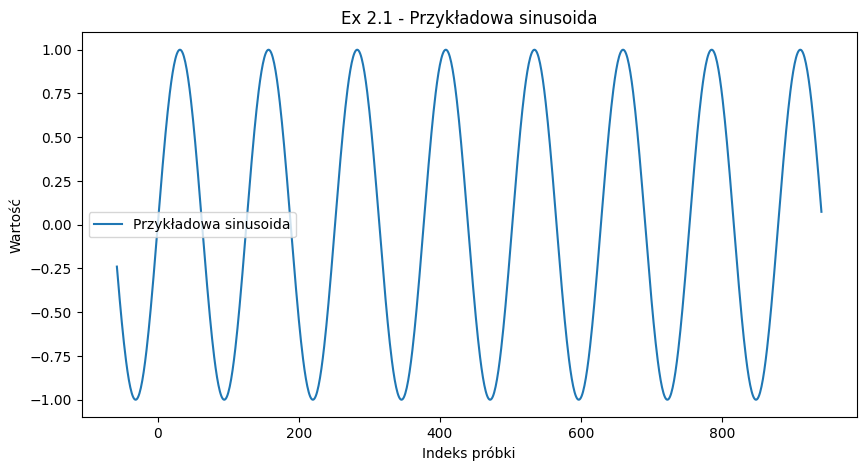

In [1]:
# Exercise 2.1 
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim


N = 10  
L = 1000 
T = 20 


x = np.empty((N, L), np.float32)
x[:] = np.arange(L) + np.random.randint(-4*T, 4*T, N).reshape(N, 1)
y = np.sin(x / T).astype(np.float32)


plt.figure(figsize=(10, 5))
plt.plot(x[0], y[0], label="Przykładowa sinusoida")
plt.xlabel("Indeks próbki")
plt.ylabel("Wartość")
plt.title("Ex 2.1 - Przykładowa sinusoida")
plt.legend()
plt.show()



In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


N = np.random.randint(5, 20)  
L = np.random.randint(800, 1200)  
T = np.random.randint(10, 30)  


x = np.empty((N, L), np.float32)
x[:] = np.arange(L) + np.random.randint(-4*T, 4*T, N).reshape(N, 1)
y = np.cos(np.sin(x / T) ** 2).astype(np.float32)


train_prop = 0.7
train_samples = round(N * train_prop)
test_samples = N - train_samples

train_input = torch.from_numpy(y[test_samples:, :-1])
train_target = torch.from_numpy(y[test_samples:, 1:])
test_input = torch.from_numpy(y[:test_samples, :-1])
test_target = torch.from_numpy(y[:test_samples, 1:])

print(f"Liczba próbek w zbiorze testowym: {test_samples}")


class LSTM(nn.Module):
    def __init__(self, hidden_layers=64):
        super().__init__()
        self.hidden_layers = hidden_layers
        self.lstm = nn.LSTM(1, self.hidden_layers, 2) 
        self.linear = nn.Linear(self.hidden_layers, 1)

    def forward(self, y, future_preds=0):
        input_t = y.t().unsqueeze(2)
        h_t2, (h_t, c_t) = self.lstm(input_t)
        output = self.linear(h_t2).squeeze(2).t()
        output1 = output[:, -1].unsqueeze(0).unsqueeze(2)

        for _ in range(future_preds):
            h_t2, (h_t, c_t) = self.lstm(output1, (h_t, c_t))
            output1 = self.linear(h_t2)
            output = torch.cat((output, output1.squeeze(0)), 1)

        return output

model = LSTM()
criterion = nn.MSELoss()
optimiser = optim.LBFGS(model.parameters(), lr=0.08)


def training_loop(n_epochs, model, optimiser, loss_fn, train_input, train_target, test_input, test_target):
    for i in range(n_epochs):
        def closure():
            optimiser.zero_grad()
            out = model(train_input)
            loss = loss_fn(out, train_target)
            loss.backward()
            return loss

        optimiser.step(closure)

        with torch.no_grad():
            future = 1000
            pred = model(test_input, future_preds=future)
            loss = loss_fn(pred[:, :-future], test_target)
            y = pred.detach().numpy()

        plt.figure(figsize=(12, 6))
        plt.title(f"Epoka {i+1}")
        plt.xlabel("Indeks próbki")
        plt.ylabel("Wartość")

        n = train_input.shape[1]

        def draw(yi, colour):
            plt.plot(np.arange(n), yi[:n], colour, linewidth=2.0)
            plt.plot(np.arange(n, n+future), yi[n:], colour+":", linewidth=2.0)

        draw(y[0], 'r')
        draw(y[1], 'b')
        draw(y[2], 'g')

        plt.show()

        out = model(train_input)
        loss_print = loss_fn(out, train_target)
        print(f"Epoka {i+1}, Loss: {loss_print}")

training_loop(n_epochs=2, model=model, optimiser=optimiser, loss_fn=criterion,
              train_input=train_input, train_target=train_target, 
              test_input=test_input, test_target=test_target)


Liczba próbek w zbiorze testowym: 3
